# Analysis

Imports

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

## Experiment 1: Delay test 1


Test setup: connect 2 devices in normal operation mode, both free to rotate on table.

![Image of the setup](assets/exp1_setup.png "Image of the setup")

We press activation button at the same time and record the positions at 33Hz. We can then plot the data and analyse the delay between the leader and the follower.

Caveats:
- Human error when "simultaneously" pressing the button
- Serial delay not taken into account (although both are transmitting through serial at the same baudrate, so idk) 



Loading the experiment data

In [2]:
leader_df = pd.read_csv("data/experiment1/leader.txt", header=None).rename(columns={0: "leader"})
leader_df.describe()

,leader
count,836.000000
mean,0.711784
std,0.396774
min,0.000000
25%,0.354869
50%,1.000000
75%,1.000000
max,1.000000


In [3]:
follower_df = pd.read_csv("data/experiment1/follower.txt", header=None).rename(columns={0: "follower"})

def mapRange(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min;s

# scale the follower data to a [0, 1] range
follower_df["follower"] = follower_df["follower"].apply(lambda x: mapRange(x, follower_df["follower"].min(), follower_df["follower"].max(), 0, 1))
follower_df.describe()

,follower
count,796.000000
mean,0.627619
std,0.365588
min,0.000000
25%,0.222061
50%,0.846540
75%,0.909251
max,1.000000


In [4]:
all_df = pd.concat([leader_df, follower_df], axis=1)
# Transform the index into a time series, each index is 30ms
period = 30 # ms
all_df.insert(0, "time", all_df.index * period)

# Remove nan values
all_df.dropna(inplace=True)

all_df.head()

,time,leader,follower
0,0,1.000000,0.940270
1,30,1.000000,0.928795
2,60,1.000000,0.928965
3,90,0.995318,0.929020
4,120,1.000000,0.929864


In [10]:
# Time delay analysis
# using https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlation_lags.html#scipy.signal.correlation_lags

leader_signal = all_df["leader"].to_numpy()
follower_signal = all_df["follower"].to_numpy()

correlation = signal.correlate(leader_signal, follower_signal, mode="full")

lags = signal.correlation_lags(leader_signal.size, follower_signal.size, mode="full")
lag = lags[np.argmax(correlation)]
time_delay = abs(lag * period)
print(f"Estimated time delay: {time_delay}ms")

Estimated time delay: 150


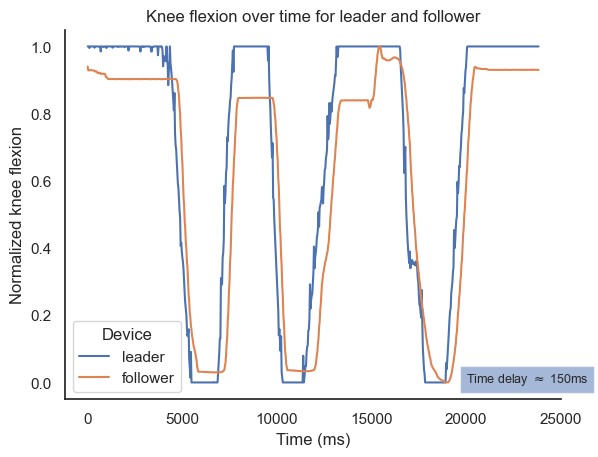

In [31]:
sns.set_theme(style="white")
sns.lineplot(
    x="time",
    y="value",
    hue="variable",
    data=pd.melt(all_df, ["time"]),
)
sns.despine()

plt.title("Knee flexion over time for leader and follower")
plt.ylabel("Normalized knee flexion")
plt.xlabel("Time (ms)")
plt.legend(title="Device")

plt.text(20000, 0, f"Time delay $\\approx$ {time_delay}ms", fontsize = 9,  
         bbox = dict(alpha = 0.5)) 

plt.show()